# Assignment 2 MLP and POS Tagging

- in this HW, you will build a part of speech (POS) tagger

    a model that assigns parts of speech, i.e., grammatical categories like "noun" and "verb" to words in a text


- by training a NN that takes a word as input (with or without its surrounding context) and then predicts the part of speech of that word


- for many words, the assignment of POS is straight forward:

    the word `bird` is always a noun,
    
    while the word `annoy` is always a verb
    
    however, there are also cases of POS ambiguity: `break` can be either a noun or verb, depending on context
    
    

- you are provided with an incomplete NumPy implementation of a multi-layer perceptron


- you need to complete the codebase, including

    - forward and backward passes for different types of network objects 
    
    - core of SGD algo


- you don't need to write many codes, but think carefully for each line


- e.g., derive array-based math expressions before implementing them in NumPy

- after complete implementation of NN, 

    you will run experiments to analyze the representations learned by your NN

# model implementation

- implement POS tagger as a MLP

## installation

- Package: NumPy, PyConll


-  PyConll: provides an interface for reading CoNLL-X file

    CoNLL-X file: a common file format used in NLP
    
    represents natural language sentences where each token is annotated with grammatical properties, including its POS tag.

In [2]:
!yes|pip install pyconll -q 

^C


## task specification and network architecture

- POS tagging task: Multinomial Classification. classify the middle token $w_0$ into one of following 17 possible POS, defined by Universal Dependencies project

- input: an n-gram, where n is odd and $k=(n-1)/2$

    $$
    w = w_{-k}\ w_{-k+1}\ ...\ w_{-1}\ w_{0}\ w_{1}\ w_{2}\ ...\ w_{k}
    $$

- figure 1 is architecture of NN POS tagger you will implement for this task


- the net consists of an embedding layer, an output layer and a variable number of hidden layers determined by hyperparameter h


different parts of the model

- input representation

    input: mini-batch of n-grams, a 2D array of shape (batch_size, n)
    
    each row (set of entries along dim 0) of the array represents an n-gram
    
    each column (set of entries along dim 1) represents all $w_is$ in the batch for some position i where $-k \leq i \leq k$
    
    entries of matrix are indices: integers that represent one of the possible tokens in the vocabulary, including `[UNK]`, `[BOS]`, `[EOS]` tokens
    
    
- embedding layer

    input: a batch of indices
    
    output: a 3D array of shape (batch_size, n, embedding_size), replace each index with its corresponding word embedding vector
    
    embedding layer is parameterized by a word embedding matrix of shape (vocabulary_size, embedding_size)


- hidden layers

    each hidden layer: a linear layer followed by a tanh activation function
    
    output of hidden layer: a 2D array of shape (batch_size, hidden_size), a batch of vectors called **hidden representations**
    
    hidden size is a hyperparameter
    
    hidden representations are latent features computed by the net: we don't know what they represent or how to interpret them
    
    input of 1st hidden layer: a 2D array of shape (batch_size, $n \times$ embedding_size), contains output of Embedding layer - all the embeddings in the mini-batch **concatenated** together
    
    input of other hidden layers: a 2D array of shape (batch_size, hidden_size), contains outputs of previous hidden layers.
  

- output layer

    final layer of the net
    
    only has a linear layer
    
    for computational efficiency, we exclude softmax activation function from output layer,
    
    instead use softmax as part of **cross-entropy loss** function
    
    output of output layer: a 2D array of shape (batch_size, 17), contains cofidence scores assigned by model to each of 17 possible POS tags
    
    these scores are on the **logit scale**: means softmax of these scores is a probability distribution over possible POS tags
    
    each row of output: interpret column contains **highest confidence score** to represent the predicted POS tag for the corresponding item in mini-batch

**Hyperparameters**

- vocabulary size: 100 (vocabulary contains 100 words)
    
- length of n-grams (context window size): n=3  (k=1)
    
- embedding size: 50
    
- hidden size: 16
    
- number of hidden layers: h=1

### Problem 1

- how many trainable params does NN have?

    i.e. how many array entires are there among the embedding matrix as well as the weight matrix and bias vector for all the hidden layers and the output layer?
    
    500 + 2,400 + 16 + 272 + 17 = 3205 params

    Embedding layer: 
    
    The number of entries in the embedding matrix: vacabulary size x embedding size = 100 x 50 = 500
    
    Hidden layer:

    The number of entries in weight matrix for hidden layers: length of n-gram x embedding size x hidden size = 3 x 50 x 16 = 2400
    
    The number of entries in bias vector for hidden layers hidden_size = 16
    
    Output layer:

    The number of entries in weight matrix for output layer: hidden size x number of POS classes = hidden_size x 17 = 16 x 17 = 272
    
    The number of entries in bias vector for output layer: number of POS classes = 17


- which part of the net has the most params?

    hidden layer has the most params: 2400+16=2416

## starter code

- `data` file

    - `en_ewt-ud-train.conllu`
    
    - `en_ewt-ud-dev.conllu`
    
    - `en_ewt-ud-test.conllu`
    
    - `glove_embeddings.txt`
    
    - `unambiguous_pos_tags.csv`


- `data_loader.py`

- `layers.py`

- `loss.py`

- `metrics.py`

- `model.py`

- `train.py`

- 3 `.conllu` files contain the sentences used for training, validating, testing our POS tagger

    dataset files are in CoNLL-U format, a variant of CoNLL-X


- `glove_embeddings.txt` is similar to `word2vec_embedding.txt` from HW1,

    except the word embeddings are trained using GloVe model instead of word2vec model
    

- `unambiguous_pos_tag.csv` will be used in Part 2 Analysis


- `.py` files are Python modules can be used by

    `from` module_name `import` function_name
    
    Note: module_name don't contain `.py` extension
    
    a collection of modules within a folder is a package

### modules belong to 3 functional categories:

#### Data Interface



- Data Interface: `data_loader` module
    
   - contains function that read CoNLL-X files and convert them into Python data structure that you will use in other parts
    
   - `load_embeddings` function: loads GloVe embeddings from `glove_embeddings.txt` file, save in binary format as a Pickle file; 2nd time it runs, loads the binary file more quickly
    
   - 2 classes
   
       - `data_loader.Vocabulary`: `Vocabulary` class is a collection of possible tokens and a mapping of each token form to **index** (a unique numerical identifier)
       
       you need to create 2 `Vocabulary` objects in this hw: 1) represents possible tokens in the text 2) represents possible POS tags
       
       - `data_loader.Dataset`: `Dataset` class is a collection of n-grams, where n is odd, labeled with POS tag of the token in the middle.
       
       `from_conll` function: load data from a CoNNL-X file and convert it into NumPy arrays. like `load_embeddings` function, it will store binary version of data which will be loaded more quickly on subsequent calls
       
       `get_batches` function: divide the data into mini-batches
       

#### Neural Network Components

- `layers`: 

    contains 3 classes for 3 types of network layers: `Embedding, Linear, Tanh`
    
    you need to complete forward and backward computations in 3 classes


- `model`

    contain `MultiLayerPerceptron` class: represent full NN you will train
        
    an object of `MultiLayerPerceptron` class contains objects of various layer types, which are assembled into the model architecture.
        
    `forward` and `backward` methods perform the forward and backward computations for each layer in appropriate order


- `loss`

    combines softmax activation function of NN with cross-entropy loss
    
    you will find that implement them together is more efficient than separately
    
    you need to complete backward computation of this combined softmax-loss function unit

- `layers.Layer` class is the heart of these 3 classes

    an abstract class that represents NN layers
    
    `clear_grad` function: reset gradients to 0
    
    `update` function: update params during SGD
    
    each subclass of `Layer` must implement a `forward` function and a `backward` function
    
    constructore `__int__` method of each `Layer` subclass must declare its params and place them within the `params` dict
    
    `Layer` objects can be called as functions: has effect of calling `forward` function while saving the input to forward

In [18]:
import numpy as np
from layers import Linear 

linear = Linear(2,3)

x = np.random.rand(5,2)

# calls linear.forward
print(linear(x)) 

# stored layer input
print(linear.x) 

None
[[0.4624437  0.56261365]
 [0.64861945 0.04784365]
 [0.68551794 0.67131176]
 [0.52889726 0.34930681]
 [0.8707156  0.00556034]]


- when working with `Layers`, you should always run the forward pass by calling the `Layer` object, rather than call `forward` function directly


- `model.MultiLayerPerceptron` and `loss.CrossEntropySoftmaxLoss` are also subclasses of `layers.Layer`,

    though they represent objects that aren't typically NN layers
    
    reason: both classes can be included in a computation graph, require a forward and backward implementation, making them compatible with `Layer` interface

#### training and evaluation code

remaining modules are used for training, validating, testing a POS tagger

- `train`

    contains functions to train and test your net
    
    below `if __name__ == "__main__"`, also contains a Python script that can be called from the command line
    
    doing so will train a network using SGD with one particular configuration of hyperparams and test the performance with the best validation accuracy


- `metrics`

    assessment of average loss and accuracy, which will be used during training

## forward computations

- in this part, you will implement forward pass for the `layers.Tanh` activation function and `layers.Linear` layer


- forward pass for the `layers.Embedding` layer and `model.MultiLayerPerceptron` model has already been implemented

### problem 2

- implement forward pass for the `layers.Tanh` activation function


- use `np.tanh` function for forward pass

In [ ]:
def forward(self, x: np.ndarray) -> np.ndarray:
    """
    Problem 2: Apply the tanh function to the input. You may add
    code to the __init__ method if you would like.

    :param x: An input to tanh. Shape: any shape
    :return: The tanh of x. Shape: the same shape as x
    """
    self.x = x 
    return np.tanh(x) 

### problem 3

- implement forward pass for the `layers.Linear` layer


- `forward` function should return: value of linear map

$$
Wx+b
$$

where x is input, W is weight matrix of the layer, b is bias vector


- you need to retrieve params from `params` dict

    W: `self.params['w']`
    
    b: `self.params['b']`

Hints:

1. do computation via matrix multiplication rather than loops

    otherwise too slow
    

2. `Linear` must can be apply to matrices of shape (batch_size, hidden_size) or (batch_size, n x embedding_size)

    but the weight matrix has shape (output_size, input_size) and bias vector has shape (output_size, )
    
    means you can't do matrix multiplication exactly as equation above,
    
    you need **transpose one** of arrays in forward pass: **`self.params['w']`**

In [ ]:
def forward(self, x: np.ndarray) -> np.ndarray:
    """
    Problem 3: Apply the linear map given by self.params. The input
    to this layer is a batch of vectors, arranged into a 3D array.
    This function must apply the linear map to each vector in the
    batch.

    :param x: A batch of input vectors. Shape: (batch size, input size)
    :return: The result of applying the linear map implemented by
        this layer to x. Shape: (batch size, output size)
    """
    return x @ (self.params['w']).T + self.params['b']

## backward computations

- in this part, you will implement backward pass for the `layers.Tanh` activation function, `layers.Linear` layer and `model.MultiLayerPerceptron` model


- backward pass for the `layers.Embedding` layer has already been implemented

### problem 4

- implement backward pass for the `layers.Tanh` activation function


- gradient of tanh

    $$
    \frac{\partial tanh(\mathbf{x})}{\partial \mathbf{x}}=1- tanh(\mathbf{x})^2
    $$


- input to `backward` is Jacobian $\delta$

    $$
    \delta =\frac{\partial \mathcal{L}}{\partial tanh(\mathbf{x})}
    $$

    shape of $\delta$ is same as input $tanh(\mathbf{x})$

    each entry of $\delta$ contains the partial derivative of $\mathcal{L}$ w.r.t corresponding entry of $tanh(\mathbf{x})$


- output of `backward` is Jacobian

    $$
    \frac{\partial \mathcal{L}}{\partial \mathbf{x}}= \delta \frac{\partial tanh(\mathbf{x})}{\partial \mathbf{x}}
    $$

    an array of same shape as $\mathbf{x}$ 

    each entry contains partial derivative of $\mathcal{L}$ w.r.t corresponding entry of $\mathbf{x}$

In [ ]:
def backward(self, delta: np.ndarray) -> np.ndarray:
    """
    Problem 4: Implement the backward pass for the tanh function.
    Since this layer has no parameters, self.grad does not need to
    be updated. You may add code to the __init__ method if you would
    like.

    :param delta: The gradient of the objective with respect to this
        layer's output. Shape: the same shape as self.x
    :return: The gradient of the objective with respect to self.x.
        Shape: the same shape as self.x
    """
    return delta * (1- (np.tanh(self.x))**2)

### problem 5

- implement `backward` function for `layers.Linear` layer


- in addition to returning Jacobian $\frac{\partial \mathcal{L}}{\partial \mathbf{x}}$, 

    you also need to update following values:
    
    `self.grad['w']`: gradients of objective $\mathcal{L}$ w.r.t weight matrix $\mathbf{W} \in \mathbb{R}^{p \times q}$
    
    $$
    \nabla _W \mathcal{L} = \left ( \frac{\partial \mathcal{L}}{\partial W} \right )^T  \in \mathbb{R}^{p \times q}
    $$
    
    `self.grad['b']`: gradients of objective L w.r.t bias vector $\mathbf{b} \in \mathbb{R}^{q}$

    $$
    \nabla _b \mathcal{L} = \left ( \frac{\partial \mathcal{L}}{\partial b} \right )^T  \in \mathbb{R}^{q}
    $$
    
    
- the shape of these gradients are arrays same as their respective params
    
    if $\mathbf{W} \in \mathbb{R}^{p \times q}$, then $\nabla _W \mathcal{L} \in \mathbb{R}^{p \times q}$, while $\frac{\partial \mathcal{L}}{\partial W}$ is a $1 \times p \times q$ **3D array** (a tensor)
    
    the transpose operation is just getting rid of first dim with only one row


- you should compute gradients $\nabla _w \mathcal{L} $ and $\nabla _b \mathcal{L} $ using **chain rule** 

    and add them to existing values stored in `self.grad` using **gradient accumulation**
    
    `self.grad["w"] +=`
    
    `self.grad["b"] +=`

In [ ]:
def backward(self, delta: np.ndarray) -> np.ndarray:
    """
    Problem 5: Implement the backward pass for the linear layer.
    This function must return the gradient of the objective with
    respect to self.x and update the gradients in self.grad.

    :param delta: The gradient of the objective with respect to the
        output of this layer. Shape: (batch size, output size)
    :return: The gradient of the objective w.r.t input of this layer. Shape: (batch size, input size)
    """
    self.grad["w"] += delta.T @ self.x 
    self.grad["b"] += delta.T @ np.ones([delta.shape[0],])
    return delta @ self.params['w']

### problem 6

- implement `backward` function of `model.MultiLayerPerceptron`


- `forward` function has already been implemented for you

    it first applies `forward` of the embedding layer,
    
    then reshapes its output to concatenate the word embeddings together,
    
    then applies the `forward` of each of the layers.
    
    remember `model.MultiLayerPerceptron` doesn't include softmax function
    

- as with `layers.Tanh`, the input to `backward` will be Jacobian $\delta$

    $$
    \boldsymbol{\delta}=\frac{\partial \mathcal{L}}{\partial \hat {\mathbf{y}}}
    $$

    where $\hat {\mathbf{y}}$ is output in Figure 1 (doesn't contain softmax)

- you code should iterate thru the list of layers in `self.layers` in reverse order,

    applying each layer's `backward` method to compute a new value of $\boldsymbol{\delta}$ representing partial derivative of the loss w.r.t the input to that layer, in accordance with the chain rule.
    
    e.g. if $\boldsymbol{z}$ is input to output layer, 
    
    then we can push $\boldsymbol{\delta}$ one step backward thru the output layer as follows:
    
    $$
    \boldsymbol{\delta} \leftarrow \frac{\partial \mathcal{L}}{\partial  \mathbf{z}}=\boldsymbol{\delta}\frac{\partial \hat {\mathbf{y}}}{\partial {\mathbf{z}}}
    $$

- Note: provided implementation of `layers.Embedding.backward` and `layers.Linear.backward` 

    store the gradients w.r.t their params in the `grad` dict 

    in addition to returning the gradients w.r.t their inputs

Hint

1. express computation in matrix operations, rather than for loops

    work thru derivative on pencil and paper
    
    1. apply chain rule to compute derivatives w.r.t individual units, weights, biases
    
    2. express formulas in matrix form: matrix addition, matrix multiplication, matrix transpose, elementwise operation


2. Note: output and $\boldsymbol{\delta}$ of `Embedding` layer has shape (batch_size, n, embedding_size),

    while output of `backward` function for 1st `Linear` layer (i.e. 1st layer in `layers` list) has shape (batch_size, n x embedding_size)
    
    when propagating gradient to `Embedding`, 
    
    you need to reshape $\boldsymbol{\delta}$ to correct shape by un-concatenating word embeddings in n-gram

In [49]:
# Reshape the embeddings by concatenating them together
layer_input = embeddings.reshape((len(ngrams),n,-1))

In [50]:
layer_input.shape 

(5, 3, 40)

In [ ]:
def backward(self, delta: np.ndarray):
    """
    Problem 6: Implement the backward pass. This function needs to
    call the backward function of self.embedding_layer and all
    layers in self.layers. It does not need to return anything.

    :param delta: The gradient of the objective with respect to the
        logit scores produced by self.forward. Shape: (batch size,
        number of POS tags)
    """
    for layer in reversed(self.layers):
        delta = layer.backward(delta)

    self.layers.Embedding.backward(delta.reshape(-1,self.ngram_len,self.embedding_size))


## Stochastic gradient descent

- SGD is implemented by `layers.Layer.update` function, 

    which updates params (in `params` dict) of a layer based on gradients (in `grad` dict) previously computed by `backward`

### problem 7

- implement `update` function for `layers.Layer` base class

    this will implement SGD for all layers in `layers` in one fell swoop,
    
    since those layers don't override `update` function

In [ ]:
def update(self, lr: float):
    """
        Problem 8: Implement the SGD update for MultiLayerPerceptron.
        This function must update the parameters of self.embedding_layer
        as well as all the layers in self.layers.

        :param lr: The learning rate
        """
    for p in self.params:
        self.params[p] -= lr * self.grad[p]
    
    self.clear_grad()

### problem 8

- implement `update` function for `models.MultiLayerPerceptron`,

    this function will need to call `update` on embedding layer and all the hidden layers and output layer of the MLP

In [ ]:
def update(self, lr: float):
    """
    Problem 8: Implement the SGD update for MultiLayerPerceptron.
    This function must update the parameters of self.embedding_layer
    as well as all the layers in self.layers.

    :param lr: The learning rate
    """
    self.embedding_layer.update(lr)

    for layer in (self.layers):
        layer.update(lr)

## softmax and cross-entropy loss

- softmax activation function:

    $$
    \text{softmax}(\mathbf{x})=\frac{e^{\mathbf{x}}}{\boldsymbol{1}^T e^{\mathbf{x}}}
    $$


- cross-entropy loss for a single example

    $$
    L_{CE}(\text{softmax}(\hat {\mathbf{y}}),y)=- \ln(\text{softmax}(\hat {\mathbf{y}})_y)=-\ln \left ( \frac{e^{\hat {\mathbf{y}}_y}}{\boldsymbol{1}^T e^{\hat {\mathbf{y}}}}
    \right )=-\ln \left ( \frac{e^{\hat {\mathbf{y}}_y}}{\sum _{i=1}^{17}e^{\hat {\mathbf{y}}_i} }\right )
    $$

- $\hat {\mathbf{y}} \in \mathbb{R}^{17}$ is a probability vector,

    where $\hat {\mathbf{y}}_y$ is the logit (confidence score) assigned by the MLP model to the correct POS tag
        
    $\text{softmax}(\hat {\mathbf{y}}_y) \in [0,1]$ is the probability that the correct label is class y

- $y \in \left\{1,2,...,17 \right\}$ is groud truth scalar label 
    
- e.g., consider the 3-gram `[BOS] The cat`. 

    the middle word `The` is a determiner ("DET"), which is item 5 in the POS tag vocabulary. 
    
    Therefore for this 3-gram input, label y = 5. 
    
    $\hat {\mathbf{y}}_5$ is the confidence (before softmax) 
    
    MLP model has $\hat {\mathbf{y}}_5$ confidence that POS tag for word `The` in the 3-gram context `[BOS] The cat` should be "DET".

- unfortunately, softmax function suffers from numerical stability:

    because $e^x$ grows extremely quickly relative to $x$,
    
    implementing softmax directly from its def may lead to overflow errors,
    
    to avoid this, we shift $\mathbf{x}$ by a constant factor so that $e^x$ won't be too large

### problem 9

- implement `softmax` function in `loss` module


- on input $\hat {\mathbf{y}}$, this function should return the vector

    $$
    \text{softmax}(\hat {\mathbf{y}} - c)
    $$

    where constant $c=\max(\hat {\mathbf{y}})$ is largest entry of $\hat {\mathbf{y}}$, i.e., most positive entry

    $c$ should be computed separately for each logit vector in the batch,

    i.e., the max should be taken along the last dim

In [5]:
def softmax(x: np.array) -> np.array:
    """
    Problem 9: Implement a numerically stabilized version of softmax.

    :param x: Any array of vectors
    :return: The softmax of x - c along dimension -1, where c is the
        maximum of x along dimension -1
    """
    c = np.max(x, axis=-1, keepdims=True)
    return np.exp(x-c) / np.exp(x-c).sum(axis=-1, keepdims=True)

### problem 10

- verify your code for problem 9 is a valid implementation of softmax


- for any input vector $\mathbf{x}$ and scalar c,

    $$
    \text{softmax}(\mathbf{x}) = \text{softmax}(\mathbf{x}+c)
    $$

    i.e., softmax function is invariant to constant offsets in input

    means stabilization trick of subtracting the max entry of $\hat {\mathbf{y}}$ doesn't affect output of softmax

In [84]:
x = np.random.rand(4,5)
c = np.random.rand(1)
np.allclose(softmax(x), softmax(x + c))

True

### problem 11

- implement `forward` function of `CrossEntropySoftmaxLoss` using your implementation of softmax from Problem 10

In [ ]:
def forward(self, logits: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Problem 11: Compute the total cross-entropy loss for a batch of
    neural network predictions given a set of gold labels. You may
    add code to the __init__ method if you would like.

    :param logits: An array of logit scores. The softmax of this
        array gives the probability assigned to each POS tag. Shape:
        (batch size, number of POS tags)
    :param y: An int-valued array of gold-standard POS tag labels.
        Shape: (batch size)
    :return: A 0D (scalar) array containing the sum of the cross-
        entropy loss for all predictions in the batch
    """
    self.logits = logits 
    self.y = y 
    return -np.sum(np.log(softmax(logits)[np.arange(logits.shape[0]), y]))

In [8]:
import numpy as np 
# batch size, number of POS tags
logits = np.random.normal(size=(5, 17))

y = np.array([1,2,3,4,5]) 

logits.shape, y, softmax(logits).shape 

((5, 17), array([1, 2, 3, 4, 5]), (5, 17))

In [7]:
-np.sum(np.log(softmax(logits)[np.arange(logits.shape[0]), y]))

16.98860325942511

### problem 12

- implement `backward` function of `CrossEntropySoftmaxLoss` 


- since $\delta$ of the loss function is always 1, 

    this `backward` function doesn't take a `delta` param,
    
    its output should be $\mathbf{\delta}$ for `model.MultiLayerPerceptron` model
    
$$
\boldsymbol{\delta} = \frac{\partial \mathcal{L}}{\partial  \hat {\mathbf{y}}}=\frac{\partial }{\partial  \hat {\mathbf{y}}} L_{CE}(\text{softmax}( \hat {\mathbf{y}}), y)
$$



- as before, your output should be a matrix of shape (batch_size, 17)

    where each row: an example in input batch
    
    each column: derivative of the loss w.r.t corresponding column of $\hat {\mathbf{y}}$

- simultaneously implement **backward pass** for both cross-entropy loss function and softmax activation function


- there is a simple math expression for gradient of these 2 units put together,

    makes it more efficient to implement them as a single layer than as 2 separate layers

- Hint

1. write out def of $L_{CE}(\text{softmax}(\hat {\mathbf{y}}),y)$ and expand this expression
    
    then compute partial derivative of this expression w.r.t each entry $\hat y_i$ of output of output layer 
   
   
2. after you compute $\frac{\partial \mathcal{L} }{\partial  \hat {y_i}}$, 

    try to find a clean, array-based expression for $\boldsymbol{\delta}$

https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1

In [ ]:
def backward(self) -> np.ndarray:
    """
        Problem 12: Computes the gradient of the cross-entropy loss with
        respect to the logit scores. Since this is the root node of the
        computation graph, the backward function does not take any
        parameters. You may add code to the __init__ method if you would
        like.

        :return: The gradient of the cross-entropy loss with respect to
            the logit scores. Shape: (batch size, number of POS tags)
        """
    one_hot = np.zeros((self.logits.shape))
    one_hot[np.arange(self.logits.shape[0]), self.y] = 1
    return softmax(self.logits) - one_hot

## training code

- the final step is to train the model


- `train_epoch` and `run_trial` functions from `train.py` module implement main training procedure


- `train_epoch` trains a given model for a single epoch 

### problem 13

- compute main loop of `train.train_epoch`: start from line 31

    this for-loop iterates over mini-batches of data
    

- you need to implement one-step of SGD algo:

    1. clear the stored graidents
    
    2. perform forward pass 
    
    3. perform backward pass 
    
    4. update params of model

In [ ]:
def train_epoch(model: MultiLayerPerceptron, train_data: Dataset,
                batch_size: int, loss_function: CrossEntropyLoss, lr: float):
    """
    Trains a model for one epoch.

    :param model: A model
    :param train_data: The training data
    :param batch_size: The batch size
    :param loss_function: The loss function layer
    :param lr: The learning rate for this batch
    """
    loss_metric = AverageLoss()
    acc_metric = Accuracy()

    for i, (ngrams, pos_tags) in enumerate(train_data.get_batches(batch_size)):
        # implement one iteration of the SGD algorithm. 
        # `ngrams` contains the input to your model, 
        # `pos_tags` contains the gold-standard POS tags that model needs to predict.
        
        # clear the gradients of model
        model.clear_grad()
        # Set this variable to the output of your model, excluding softmax
        logits = model(ngrams)
        # compute total cross-entropy loss for this mini-batch
        batch_loss = loss_function(logits, pos_tags)
        # run backpropagation algorithm to compute gradients of model for this mini-batch
        model.backward(loss_function.backward())
        # update the parameters
        model.update(lr)

        # Update metrics (loss and accuracy)
        avg_batch_loss = loss_metric.update(batch_loss, len(ngrams))
        batch_acc = acc_metric.update(logits, pos_tags)
        if (i + 1) % 100 == 0:
            print_metrics(avg_batch_loss, batch_acc, "Batch {}".format(i + 1))

    # Report epoch results
    print_metrics(loss_metric.value, acc_metric.value, "Training Complete")


- once you implemented the training loop, 

    there are 2 ways you can train the model
    
1. call `train.py` file as a script 
    
    in Terminal: `python train.py`
        
    in Jupyter notebook: `!python train.py`
   
   
2. recreate training script at the bottom of `train.py` file in your own script or Jupyter Notebook

    `from train import run_trial` 


- we won't grade any scripts you write for training the model

    don't submit any extra Python scripts or Jupyter Notebook with submissions

# analysis

- understand what your neural network has learned during training

## Part of Speech ambiguity

- most English words only have one POS,

    for these words, the net simply needs to memorize their POS tags
    
    words with multiple POS are more challenging for the model
    
    can your trained net handle these more difficult cases?

### problem 14

- find 3 words that can take on > 1 POS

    for each word, give two 3-grams with your word in the middle
    
    one that forces your word to have 1 POS;
    
    one that forces your word to have a different POS

In [7]:
tokens_list = [
    ['is', 'flying', 'across'], # word1: flying, unambiguious: VERB
    ['[BOS]', 'Flying', 'planes'], # word1: flying, ambiguious: VERB or NOUN
    ['The', 'flies', 'died'], # word2: flies, unambiguious: NOUN
    ['Time', 'flies', 'like'], # word2: flies, ambiguious: VERB OR NOUN
    ['I', 'fire', 'him'], # word3: fire, unambiguious: VERB
    ['green', 'fire', 'truck'] # word3: fire, ambiguious: VERB or NOUN
]

### problem 15

- train a 3-gram POS tagger and feed your six 3-grams from Problem 14 into your POS tagger


- report the testing accuracy of your model

    make sure that it's >= 75%
    

- what POS tags does your tagger assign to the six 3-grams?

    for which of the 3-grams does your model make a correct prediction?

Hints:

1. try using the following hyperparams for training your model:

    learning rate 0.1, batch size 5, step size 4, $\gamma = 0.25$, 1 layer
    

2. use the following template in a Python script or Jupyter Notebook to run your model on a 3-gram

- test accuracy is 76.8%


- The model made a correct prediction for the 3-grams below:

    'is flying across' ['VERB'] 

    'I fire him' ['VERB'] 

In [1]:
!pwd 

/Users/wenxinxu/Desktop/LING 780/homework/hw 2 n-Gram Part of Speech Tagger/Archive


In [2]:
import pickle
import numpy as np
from data_loader import load_embeddings, all_pos_tags, Vocabulary
from model import MultiLayerPerceptron

In [ ]:
ngram_len = 3
hidden_size = 16  
num_layers = 1

# Load embeddings and vocab
all_tokens, glove_embeddings = load_embeddings()

# Only use 5,000 most common embeddings
all_tokens = all_tokens[:5000]
glove_embeddings = glove_embeddings[:5000]

# create vocabularies
token_vocab = Vocabulary(all_tokens + ["[UNK]", "[BOS]", "[EOS]"])
pos_tag_vocab = Vocabulary(all_pos_tags)

['NOUN']


In [4]:
# Create model: with pretrained embedding
model = MultiLayerPerceptron(len(token_vocab), len(pos_tag_vocab),
                                ngram_len, pretrained_embeddings.shape[-1],
                                hidden_size, num_layers)

with open("checkpoint.p", "rb") as f:
        model = pickle.load(f)

In [8]:
# Load embeddings and vocab
print("Loading embeddings...")
all_tokens, glove_embeddings = load_embeddings()

# Only use the 5,000 most common embeddings
all_tokens = all_tokens[:5000]
glove_embeddings = glove_embeddings[:5000]
print("Done.")


Loading embeddings...
Done.


In [6]:
# create vocabularies
token_vocab = Vocabulary(all_tokens + ["[UNK]", "[BOS]", "[EOS]"])

pos_tag_vocab = Vocabulary(all_pos_tags)

# prepare model input
tokens = ['Hello', 'world', '!']

ngrams = np.array(token_vocab.get_ngrams(tokens, 3))[1:2]

# get model output
predictions = model(ngrams).argmax(axis=-1) 

pos_tags = [pos_tag_vocab.get_form(p) for p in predictions] 

print(pos_tags)

['NOUN']


In [8]:
for tokens in tokens_list:
    
    ngrams = np.array(token_vocab.get_ngrams(tokens, 3))[1:2]

    # get model output
    predictions = model(ngrams).argmax(axis=-1) 

    pos_tags = [pos_tag_vocab.get_form(p) for p in predictions] 

    print(pos_tags)


['VERB']
['PRON']
['PRON']
['NOUN']
['VERB']
['NOUN']


### problem 16

- find 3 symmetrical skip-grams with window size 1,

    i.e., three 3-grams with the middle word missing
    
    such that only words belonging to 1 particular POS can be inserted into middle of skip-gram
    

- then, form three 3-grams by inserting `[UNK]` into middle of your 3 skip-grams


- what POS tag is assigned to your three 3-grams by the POS tagger you trained in Problem 15?

In [10]:
skip_grams_list = [
    ['The', '[UNK]', 'meows'], # NOUN
    ['A', '[UNK]', 'cake'], # ADJ
    ['He', '[UNK]', 'away'] # VERB
]

In [11]:
for tokens in skip_grams_list:
    
    ngrams = np.array(token_vocab.get_ngrams(tokens, 3))[1:2]

    # get model output
    predictions = model(ngrams).argmax(axis=-1) 

    pos_tags = [pos_tag_vocab.get_form(p) for p in predictions] 

    print(pos_tags)


['PROPN']
['PROPN']
['NOUN']


 - The POS tag assigned to my three 3-grams by the POS tagger I trained in Problem 15 is:
 
    'The [UNK] meows': expected NOUN, but got PROPN
 
    'A [UNK] cake': expected ADJ, but got PROPN
    
    'He [UNK] away': expected VERB, but got NOUN

## POS and word embeddings

- POS tagging model learns embeddings that are optimized to carry out the tagging task


- in this final part, you will consider the structure of this embedding space and how it facilitates the task of POS tagging


- we will focus on embeddings of POS-unambiguous words

    i.e., words that appear tagged with only a single POS in the training data
    

- POS-ambiguous words will be represented as some combination of multiple POS with which they're associated (sensitive to freq with which they occur in each)

    and therefore won't be easily interpretable

- in `data` folder a CSV file `unambiguous_pos_tags.csv` contains all POS-unambiguous words from training set


- you can load these words, together with their corresponding POS tags, using Python's `csv` module

In [ ]:
unambig_pos_tags

[['!', 'PUNCT'],
 ['#', 'SYM'],
 ["''", 'PUNCT'],
 ["'d", 'AUX'],
 ["'ll", 'AUX'],
 ["'re", 'AUX'],
 ["'ve", 'AUX'],
 [',', 'PUNCT'],
 ['--', 'PUNCT'],
 ['.', 'PUNCT'],
 ['.....', 'PUNCT'],
 ['0', 'NUM'],
 ['1,000', 'NUM'],
 ['1.5', 'NUM'],
 ['10', 'NUM'],
 ['10,000', 'NUM'],
 ['100', 'NUM'],
 ['100,000', 'NUM'],
 ['11', 'NUM'],
 ['11th', 'NOUN'],
 ['12', 'NUM'],
 ['120', 'NUM'],
 ['12th', 'NOUN'],
 ['13', 'NUM'],
 ['14', 'NUM'],
 ['15', 'NUM'],
 ['150', 'NUM'],
 ['16', 'NUM'],
 ['16th', 'PROPN'],
 ['17', 'NUM'],
 ['18', 'NUM'],
 ['18th', 'ADJ'],
 ['19', 'NUM'],
 ['1943', 'NUM'],
 ['1945', 'NUM'],
 ['1949', 'NUM'],
 ['1960s', 'NOUN'],
 ['1962', 'NUM'],
 ['1964', 'NUM'],
 ['1967', 'NUM'],
 ['1968', 'NUM'],
 ['1969', 'NUM'],
 ['1970', 'NUM'],
 ['1970s', 'NOUN'],
 ['1971', 'NUM'],
 ['1972', 'NUM'],
 ['1973', 'NUM'],
 ['1974', 'NUM'],
 ['1978', 'NUM'],
 ['1980', 'NUM'],
 ['1980s', 'NOUN'],
 ['1982', 'NUM'],
 ['1983', 'NUM'],
 ['1984', 'PROPN'],
 ['1986', 'NUM'],
 ['1987', 'NUM'],
 ['1989',

- to explore high-dim embeddings of these words,

    we must perform dim reduction, use t-SNE, 
    
    important point: nearby points in low-dim space that t-SEN produces will correspond to nearby points in high-dim space,
    
    i.e., embedding is roughly isometric

- to create t-SNE embeddings, look up the embedding correspond to words in `unambig_pos_tags` list you just created


- given an embedding matrix `embeddings`, you can just do this for the first 1000 embeddings

    and produce a 2D plot

    reason: perform t-SNE for large sets is computationally expensive 

## problem 17

### question 1

1. initialize a `MultiLayerPerceptron` model without loading pre-trained GloVe embeddings 

    and create t-SNE plots for the model's randomly initialized embeddings
    

2. train the model until it reaches >= 75% accuracy,

    create t-SNE plots for model's trained word embeddings
    
    
- How does these plots compare?


- What does this tell us about the info encoded in net's word embeddings pre- and post-training?




### question 2

- create a t-SNE plot for pre-trained GloVe or word2vec embeddings,

    loaded from `glove_embeddings.txt` or `word2vec_embeddings.txt` file from HW1, that haven't undergone any POS-tag training
    

- what can you conclude about the degree to which pre-trained embeddings encode info about POS?

    given your knowledge of word2vec
    
    assume GloVe is also based on distributional semantics
    
- is this what you would expect? why?
    
    

### answer

- Test accuracy 76.4%


- How does these plots compare?

    The t-SNE plots for the trained word embeddings of the model with and without pretrained GloVe embeddings both do a good job of clustering the words with same POS tags together: a large gray cluster for NOUN tag, a median size brown cluster for VERB tag, a small green cluster for PUNCT tag or ADV tag, a small yellow-green cluster for NUM tag, though there are several sparse orange points tagged PROPN or ADP distributed in the NOUN cluster.


- What does this tell us about the info encoded in net's word embeddings pre- and post-training?

    The info encoded in net's word embeddings pre- and post-training is focused on the POS tagging of words because words with same POS tags clustered together.


- what can you conclude about the degree to which pre-trained embeddings encode info about POS?

    The t-SNE plot for pre-trained word embeddings of GloVe has no obvious clusters of tags with randomly distributed points.


- Is this what you would expect? why?

    Yes, because distributional semantics believes that the meaning of a word can be inferred from its usage - its distribution in text, i.e., words with similar distributions have similar meanings, so they should cluster together. But the words with similar meanings may not have same POS tags, so when the embeddings are colored by tags, they seem to be randomly distributed points.

In [ ]:
!pwd 

/Users/wenxinxu/Desktop/LING780/homework/hw 2 n-Gram Part of Speech Tagger/Archive


In [ ]:
from data_loader import load_embeddings, all_pos_tags, Vocabulary
from sklearn.manifold import TSNE
from model import MultiLayerPerceptron
import matplotlib.pyplot as plt
import csv 
import pickle
import warnings  

In [ ]:
# Hyperparameters
ngram_len = 3
hidden_size = 16  
num_layers = 1

# Load embeddings and vocab
all_tokens, glove_embeddings = load_embeddings(filename = "data/glove_embeddings.txt")

# Only use 5,000 most common embeddings
all_tokens = all_tokens[:5000]  # length 5000
glove_embeddings = glove_embeddings[:5000]  # (5000, 100)

# create vocabularies
token_vocab = Vocabulary(all_tokens + ["[UNK]", "[BOS]", "[EOS]"])
pos_tag_vocab = Vocabulary(all_pos_tags)

# open a csv file for reading
with open("data/unambiguous_pos_tags.csv", "r") as f: 
    # convert CSV file to a list, remove header row
    unambig_pos_tags = list(csv.reader(f))[1:]

In [ ]:
# initialize models
glove_model = MultiLayerPerceptron(len(token_vocab), len(pos_tag_vocab),
                                ngram_len, glove_embeddings.shape[-1],
                                hidden_size, num_layers)

random_model = MultiLayerPerceptron(len(token_vocab), len(pos_tag_vocab),
                                ngram_len, 100,
                                hidden_size, num_layers)
# extract untrained embeddings
untrained_glove = glove_model.embedding_layer.params['embeddings']
untrained_random = random_model.embedding_layer.params['embeddings']

# load trained model
with open("./checkpoint/checkpoint1.p", "rb") as f:
        glove_model = pickle.load(f)
with open("./checkpoint/checkpoint2.p", "rb") as f:
        random_model = pickle.load(f)

# extract trained embeddings
trained_glove = glove_model.embedding_layer.params['embeddings']
trained_random = random_model.embedding_layer.params['embeddings']

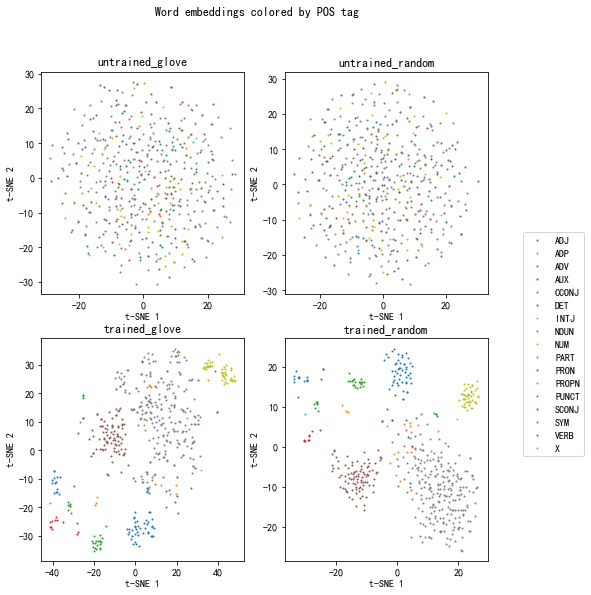

In [ ]:
embeddings = [untrained_glove, untrained_random, trained_glove, trained_random]
titles = ['untrained_glove', 'untrained_random', 'trained_glove', 'trained_random']
fig, axes = plt.subplots(2, 2, figsize=(8, 9))

for ax, embed, title in zip(axes.flatten(), embeddings, titles):
    embed = embed[:1000]
    # Suppress warnings of t-SNE 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne_embeddings = TSNE(n_components=2).fit_transform(embed)

    for pos in pos_tag_vocab.forms:
        # get indices for all words whose POS tag is unambiguous
        indices = [token_vocab.get_index(w) for w, p in unambig_pos_tags if p == pos] 
        # remove indices outside of the first 1,000 words
        indices = [i for i in indices if i < 1000]
        # add points for these indices to the plot, assign a unique color to this POS tag
        ax.plot(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1],
                marker=".",linestyle="",markersize=2, label=pos) 
    ax.set_title(title)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

plt.legend(loc="best", bbox_to_anchor=(1.5, 1.5))
plt.suptitle("Word embeddings colored by POS tag")
plt.show() 